In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

wandb: Appending key for api.wandb.ai to your netrc file: /Users/guydavidson/.netrc
Successfully logged in to Weights & Biases!


In [3]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath

import pickle
import tabulate
import wandb
from collections import namedtuple

import meta_learning_data_analysis as analysis
import meta_learning_analysis_plots as plots

In [10]:
cache = analysis.refresh_cache()
print(cache.keys())

dict_keys(['six_replications_analyses', 'control_analyses', 'query_mod_replications', 'six_replications_updated_analyses', 'updated_control_analyses', 'query_mod_updated_analyses', 'forgetting_curves_raw_data', 'preliminary_maml_analyses', 'baseline_maml_comparison_analyses', 'maml_analyses', 'maml_alpha_0_analyses', 'maml_meta_test_analyses', 'balanced_batches_analyses', 'baseline_total_curve_analyses', 'control_total_curve_analyses', 'query_mod_total_curve_analyses', 'simultaneous_training_analyses', 'per_task_simultaneous_training_analyses', 'task_conditional_analyses', 'task_conditional_multiplicative_only_analyses', 'task_conditional_additive_only_analyses'])


-------

# Baseline analyses

In [ ]:
if 'six_replications_analyses' in cache:
    six_replications_analyses = cache['six_replications_analyses']

else:
    six_replications_by_dimension_runs = analysis.load_runs(60)
    print('Loaded runs')

    six_reps_dict = {dimension_name:analysis.process_multiple_runs(run_set) 
                     for run_set, dimension_name 
                     in zip(six_replications_by_dimension_runs, analysis.CONDITION_ANALYSES_FIELDS)}
    six_replications_analyses = analysis.ConditionAnalysesSet(**six_reps_dict)

    cache = analysis.refresh_cache(dict(six_replications_analyses=six_replications_analyses))


In [ ]:
# if 'six_replications_updated_analyses' in cache:
#     six_replications_updated_analyses = cache['six_replications_updated_analyses']

# else:
six_replications_by_dimension_runs = analysis.load_runs(60)
print('Loaded runs')

# note: the equal accuracy field will come in as accuracy_drops
updated_six_reps_dict = {}
start_index = 0
for run_set, dimension_name in zip(six_replications_by_dimension_runs[start_index:], 
                                   analysis.CONDITION_ANALYSES_FIELDS[start_index:]):
    updated_six_reps_dict[dimension_name] = analysis.process_multiple_runs(
        run_set, parse_func=analysis.parse_run_results_with_new_task_accuracy_and_equal_size) 

# combined_analysis = analysis.process_multiple_runs(
#     six_replications_by_dimension_runs[3], 
#     parse_func=analysis.parse_run_results_with_new_task_accuracy_and_equal_size)

six_replications_updated_analyses = analysis.ConditionAnalysesSet(**updated_six_reps_dict)

cache = analysis.refresh_cache(dict(six_replications_updated_analyses=six_replications_updated_analyses))


In [ ]:
# if 'baseline_total_curve_analyses' in cache:
#     baseline_total_curve_analyses = cache['baseline_total_curve_analyses']

# else:
six_replications_by_dimension_runs = analysis.load_runs(60)
print('Loaded runs')

analyses_per_dimension = {}

for run_set, dimension_name in zip(six_replications_by_dimension_runs, analysis.CONDITION_ANALYSES_FIELDS):
    print(f'Starting {dimension_name}')
    total_curve_raw, total_curve_mean, total_curve_std, total_curve_sem = \
        analysis.process_multiple_runs_total_task_training_curves(run_set)

    analyses_per_dimension[dimension_name] = analysis.TotalCurveResults(raw=total_curve_raw,
                                                                        mean=total_curve_mean, 
                                                                        std=total_curve_std, 
                                                                        sem=total_curve_sem)

total_curve_analyses = analysis.ConditionAnalysesSet(**analyses_per_dimension)
cache = analysis.refresh_cache(dict(baseline_total_curve_analyses=total_curve_analyses))


-------

# Control analyses

In [ ]:
if 'control_analyses' in cache:
    control_analyses = cache['control_analyses']

else:
    control_runs = analysis.load_runs(150, 'meta-learning-scaling/sequential-benchmark-control', False)
    print(f'Loaded runs')
    control_analyses = analysis.ConditionAnalysesSet(combined=analysis.process_multiple_runs(control_runs.combined))

    cache = analysis.refresh_cache(dict(control_analyses=control_analyses))

In [ ]:
# if 'six_replications_updated_analyses' in cache:
#     six_replications_updated_analyses = cache['six_replications_updated_analyses']

# else:
control_runs = analysis.load_runs(150, 'meta-learning-scaling/sequential-benchmark-control', False)
print('Loaded runs')

updated_control_analyses = analysis.ConditionAnalysesSet(
    combined=analysis.process_multiple_runs(control_runs.combined, 
                                            parse_func=analysis.parse_run_results_with_new_task_accuracy_and_equal_size))


cache = analysis.refresh_cache(dict(updated_control_analyses=updated_control_analyses))


In [ ]:
if 'control_total_curve_analyses' in cache:
    control_total_curve_analyses = cache['control_total_curve_analyses']

else:
    control_runs = analysis.load_runs(150, 'meta-learning-scaling/sequential-benchmark-control', False)
    print('Loaded runs')
    
    total_curve_raw, total_curve_mean, total_curve_std, total_curve_sem = \
            analysis.process_multiple_runs_total_task_training_curves(control_runs.combined)
    
    control_total_curve_analyses = analysis.ConditionAnalysesSet(
        combined=analysis.TotalCurveResults(raw=total_curve_raw,
                                            mean=total_curve_mean,
                                            std=total_curve_std,
                                            sem=total_curve_sem))

    cache = analysis.refresh_cache(dict(control_total_curve_analyses=control_total_curve_analyses))


In [ ]:
cache = analysis.refresh_cache(dict(control_analyses=control_analyses))

# Plot the results

## Plot the number of examples by dimension

In [ ]:
ylim = (1000, 520000)

plots.plot_processed_results(first_replication_analyses.color.examples, 'Color 10-run average', ylim)
plots.plot_processed_results(first_replication_analyses.shape.examples, 'Shape 10-run average', ylim)
plots.plot_processed_results(first_replication_analyses.texture.examples, 'Material 10-run average', ylim)

In [ ]:
ylim = (1000, 700000)

plots.plot_processed_results(six_replications_analyses.color.examples, 'Color 60-run average', ylim)
plots.plot_processed_results(six_replications_analyses.shape.examples, 'Shape 60-run average', ylim)
plots.plot_processed_results(six_replications_analyses.texture.examples, 'Material 60-run average', ylim)

## Plot the log of the number of examples to criterion, in each dimension, with error bars

## Plot the combined results over all 180 runs

In [ ]:
ylim = (7.75, 13.25)

plots.plot_processed_results(six_replications_analyses.combined.log_examples, 'Combined 180-run average', 
                       ylim, log_x=(True, True), log_y=True, sem_n=180, shade_error=True)

## Plot the absolute accuracy after introducing a new task

In [ ]:
ylim = None

plots.plot_processed_results(six_replications_analyses.color.accuracies, 'Color 60-run average', 
                       ylim, log_x=False, log_y=False, sem_n=60, shade_error=True)
plots.plot_processed_results(six_replications_analyses.shape.accuracies, 'Shape 60-run average', 
                       ylim, log_x=False, log_y=False, sem_n=60, shade_error=True)
plots.plot_processed_results(six_replications_analyses.texture.accuracies, 'Material 60-run average', 
                       ylim, log_x=False, log_y=False, sem_n=60, shade_error=True)
plots.plot_processed_results(six_replications_analyses.combined.accuracies, 'Combined 180-run average', 
                       ylim, log_x=False, log_y=False, sem_n=180, shade_error=True)

## Plot the accuracy drop after introducing a new task

In [ ]:
ylim = None

plots.plot_processed_results(six_replications_analyses.color.accuracy_drops, 'Color 60-run average', 
                       ylim, log_x=False, log_y=False, sem_n=60, shade_error=True)
plots.plot_processed_results(six_replications_analyses.shape.accuracy_drops, 'Shape 60-run average', 
                       ylim, log_x=False, log_y=False, sem_n=60, shade_error=True)
plots.plot_processed_results(six_replications_analyses.texture.accuracy_drops, 'Material 60-run average', 
                       ylim, log_x=False, log_y=False, sem_n=60, shade_error=True)

-------

# Query-modulated analyses

In [ ]:
if 'query_mod_replications' in cache:
    query_mod_replications = cache['query_mod_replications']

else:
    query_mod_runs = analysis.query_modulated_runs_by_dimension(30)
    query_mod_replications = {}

    ignore_runs = [] # ('at6pkicv', )
    for mod_level in query_mod_runs:
        mod_level_runs = query_mod_runs[mod_level]

        mod_level_dict = {dimension_name: analysis.process_multiple_runs(mod_level_runs[i], ignore_runs=ignore_runs) 
                          for i, dimension_name 
                          in enumerate(analysis.CONDITION_ANALYSES_FIELDS)}

        query_mod_replications[mod_level] = analysis.ConditionAnalysesSet(**mod_level_dict)

    cache = analysis.refresh_cache(dict(query_mod_replications=query_mod_replications))

In [ ]:
cache = analysis.refresh_cache(dict(query_mod_updated_analyses=query_mod_replications))

In [ ]:
# if 'six_replications_updated_analyses' in cache:
#     six_replications_updated_analyses = cache['six_replications_updated_analyses']

# else:
query_mod_runs = analysis.query_modulated_runs_by_dimension(30)
print('Loaded runs')

# note: the equal accuracy field will come in as accuracy_drops
query_mod_replications = {}
mod_levels = list(query_mod_runs.keys())
start_index = 0

for mod_level in mod_levels[start_index:]:
    print(f'Starting mod level {mod_level}')
    mod_level_runs = query_mod_runs[mod_level]

    mod_level_dict = {dimension_name: analysis.process_multiple_runs(mod_level_runs[i], 
                                                                     parse_func=analysis.parse_run_results_with_new_task_accuracy_and_equal_size) 
                      for i, dimension_name 
                      in enumerate(analysis.CONDITION_ANALYSES_FIELDS)}

    query_mod_replications[mod_level] = analysis.ConditionAnalysesSet(**mod_level_dict)


cache = analysis.refresh_cache(dict(query_mod_updated_analyses=query_mod_replications))


In [ ]:
cache = analysis.refresh_cache(dict(query_mod_replications=query_mod_replications,
                                    control_analyses=control_analyses,
                                    six_replications_analyses=six_replications_analyses))

In [ ]:
if 'query_mod_total_curve_analyses' in cache:
    query_mod_total_curve_analyses = cache['query_mod_total_curve_analyses']

else:
    query_mod_runs = analysis.query_modulated_runs_by_dimension(30)
    print('Loaded runs')
    
    query_mod_total_curve_analyses = {}
    mod_levels = list(query_mod_runs.keys())
    start_index = 0
    
    for mod_level in mod_levels[start_index:]:
        print(f'Starting mod level {mod_level}')
        mod_level_runs = query_mod_runs[mod_level]

        analyses_per_dimension = {}
        
        for run_set, dimension_name in zip(mod_level_runs, analysis.CONDITION_ANALYSES_FIELDS):
            print(f'Starting {dimension_name}')
            total_curve_raw, total_curve_mean, total_curve_std, total_curve_sem = \
                analysis.process_multiple_runs_total_task_training_curves(run_set)

            analyses_per_dimension[dimension_name] = analysis.TotalCurveResults(raw=total_curve_raw,
                                                                                mean=total_curve_mean, 
                                                                                std=total_curve_std, 
                                                                                sem=total_curve_sem)

        query_mod_total_curve_analyses[mod_level] = analysis.ConditionAnalysesSet(**analyses_per_dimension)
            
    cache = analysis.refresh_cache(dict(query_mod_total_curve_analyses=query_mod_total_curve_analyses))


In [ ]:
query_mod_total_curve_analyses.keys()

-------

# MAML

In [ ]:
if 'maml_analyses' in cache:
    maml_analyses = cache['maml_analyses']

else:
    maml_runs = analysis.load_runs(30, 'meta-learning-scaling/maml-sequential-benchmark')
    print('Loaded runs')

    # ignore_runs = set(['oz996ztv', 'oin8pqu2', 'h09i9xyg', 'umo8x16f', 'pm76ui1s', 
    #                    'qnyo08x8', 'hmjtjheq', 'wki7q8cs', 'q8ku840y'])
    ignore_runs = set()

    maml_analyses_dict = {}
    start_index = 0
    for run_set, dimension_name in zip(maml_runs[start_index:], 
                                       analysis.CONDITION_ANALYSES_FIELDS[start_index:]):

        maml_analyses_dict[dimension_name] = analysis.process_multiple_runs(
            run_set, parse_func=analysis.parse_run_results_with_new_task_accuracy_and_equal_size,
            ignore_runs=ignore_runs) 

    maml_analyses = analysis.ConditionAnalysesSet(**maml_analyses_dict)
    cache = analysis.refresh_cache(dict(maml_analyses=maml_analyses))


In [ ]:
# if 'six_replications_updated_analyses' in cache:
#     six_replications_updated_analyses = cache['six_replications_updated_analyses']

# else:
maml_alpha_0_runs = analysis.load_runs(20, 'meta-learning-scaling/maml-alpha-0')
print('Loaded runs')

raise ValueError('This will not work yeet')

# ignore_runs = set(['ac82mceh', '7kau3ypy', 'g9ujw7gg', 'avmcbnot'])
ignore_runs = set()

maml_alpha_0_analyses_dict = {}
start_index = 0
for run_set, dimension_name in zip(maml_alpha_0_runs[start_index:], 
                                   analysis.CONDITION_ANALYSES_FIELDS[start_index:]):
    
    maml_alpha_0_analyses_dict[dimension_name] = analysis.process_multiple_runs(
        run_set, parse_func=analysis.parse_run_results_with_new_task_accuracy_and_equal_size,
        ignore_runs=ignore_runs) 

maml_alpha_0_analyses = analysis.ConditionAnalysesSet(**maml_alpha_0_analyses_dict)
cache = analysis.refresh_cache(dict(maml_alpha_0_analyses=maml_alpha_0_analyses))


In [ ]:
if 'maml_meta_test_analyses' in cache:
    maml_meta_test_analyses = cache['maml_meta_test_analyses']

else:
    maml_meta_test_runs = analysis.load_runs(30, 'meta-learning-scaling/maml-meta-test')
    print('Loaded runs')

    # ignore_runs = set(['u3gk9oio'])
    ignore_runs = set()

    maml_meta_test_analyses_dict = {}
    start_index = 0
    for run_set, dimension_name in zip(maml_meta_test_runs[start_index:], 
                                       analysis.CONDITION_ANALYSES_FIELDS[start_index:]):

        maml_meta_test_analyses_dict[dimension_name] = analysis.process_multiple_runs(
            run_set, parse_func=analysis.parse_run_results_with_new_task_accuracy_and_equal_size,
            ignore_runs=ignore_runs) 

    maml_meta_test_analyses = analysis.ConditionAnalysesSet(**maml_meta_test_analyses_dict)
    cache = analysis.refresh_cache(dict(maml_meta_test_analyses=maml_meta_test_analyses))


In [ ]:
if 'balanced_batches_analyses' in cache:
    balanced_batches_analyses = cache['balanced_batches_analyses']

else:
    balanced_batches_runs = analysis.load_runs(30, 'meta-learning-scaling/balanced-batches-sequential-benchmark')
    print('Loaded runs')

    # ignore_runs = set(['u3gk9oio'])
    ignore_runs = set()

    balanced_batches_analyses_dict = {}
    start_index = 0
    for run_set, dimension_name in zip(balanced_batches_runs[start_index:], 
                                       analysis.CONDITION_ANALYSES_FIELDS[start_index:]):

        balanced_batches_analyses_dict[dimension_name] = analysis.process_multiple_runs(
            run_set, parse_func=analysis.parse_run_results_with_new_task_accuracy_and_equal_size,
            ignore_runs=ignore_runs) 

    balanced_batches_analyses = analysis.ConditionAnalysesSet(**balanced_batches_analyses_dict)
    cache = analysis.refresh_cache(dict(balanced_batches_analyses=balanced_batches_analyses))


In [ ]:
maml_comparison_run_ids = [1000, 1001, 2000, 2001, 2002, 
                           2003, 2004, 2005, 2006, 2007, 
                           2008, 2009, 3000, 3001, 3002, 
                           3003, 3004, 3005, 3006, 3007, 3008]

maml_comparison_runs = analysis.load_runs(10, split_runs_by_dimension=False, valid_run_ids=set(maml_comparison_run_ids))
print('Loaded runs')

baseline_maml_comparison_analyses = analysis.ConditionAnalysesSet(
    combined=analysis.process_multiple_runs(maml_comparison_runs.combined, 
                                            parse_func=analysis.parse_run_results_with_new_task_accuracy_and_equal_size,))


cache = analysis.refresh_cache(dict(baseline_maml_comparison_analyses=baseline_maml_comparison_analyses))



-----

# Simultaneous training in a dimension

In [5]:
# if 'simultaneous_training_analyses' in cache:
#     simultaneous_training_analyses = cache['simultaneous_training_analyses']

# else:
simultaneous_training_runs = analysis.load_runs(20, 'meta-learning-scaling/simultaneous-training')
print('Loaded runs')

# ignore_runs = set(['u3gk9oio'])
ignore_runs = set()

simultaneous_training_analyses_dict = {}
per_task_simultaneous_training_analyses_dict = {}
start_index = 0
for run_set, dimension_name in zip(simultaneous_training_runs[start_index:], 
                                   analysis.CONDITION_ANALYSES_FIELDS[start_index:]):

    stacked_results, all_results_mean, all_results_std, all_results_sem, per_task_results_mean, per_task_results_std, per_task_results_sem = analysis.process_multiple_runs_simultaneous_training(run_set, ignore_runs=ignore_runs)

    simultaneous_training_analyses_dict[dimension_name] = analysis.TotalCurveResults(raw=stacked_results,
                                                                                     mean=all_results_mean, 
                                                                                     std=all_results_std, 
                                                                                     sem=all_results_sem)

    per_task_simultaneous_training_analyses_dict[dimension_name] = analysis.TotalCurveResults(raw=stacked_results,
                                                                                              mean=per_task_results_mean, 
                                                                                              std=per_task_results_std, 
                                                                                              sem=per_task_results_sem)

simultaneous_training_analyses = analysis.ConditionAnalysesSet(**simultaneous_training_analyses_dict)
per_task_simultaneous_training_analyses = analysis.ConditionAnalysesSet(**per_task_simultaneous_training_analyses_dict)
cache = analysis.refresh_cache(dict(simultaneous_training_analyses=simultaneous_training_analyses,
                                    per_task_simultaneous_training_analyses=per_task_simultaneous_training_analyses))


Loaded runs
evmded6t
4zmevm81
rn1100g6
valxzdh6
vhar7vl0
btpqc0l4
y2okllq0
p6jkyns3
sdvikem3
8gbqcsiy
i1s48hvs 10
yjkmbyfn
hcj92b4t
6g91pfuh
2wzm82cl
9gh81adt
n27ud1lv
4a0fluhk
il27z68d
rdy5b4h7
93bl61z8
h0mlpimb
mskrvezv
k6lcgekj
bmlx3672
y8roqwko
0glw98lj
7ewq32s7
g6wppirc
4rwxdt1j
6jw8g94w 10
cll4tmi4
oi8y8zp9
iwbib2kn
8171o5q6
v9nzvwna
86693lo0
nluhx1qs
v3ezft64
v2y1k1zu
cwgjjrp5
0wgkxa8e
zh6j4sut
8j2j6f1u
p4fbaygn
yfohbvi8
vqavcfh8
rd60a1ls
qc4wk4kf
00fm3ms0
8misib06 10
kzwulr2p
1oe3hex8
naiw1ed2
7l3blxaz
bv2v2yeg
mgrxdvan
tkb27tai
qxtm0ddo
em7rzcfv
evmded6t
cwgjjrp5
4zmevm81
0wgkxa8e
rn1100g6
zh6j4sut
valxzdh6
8j2j6f1u
p4fbaygn
vhar7vl0
btpqc0l4 10
yfohbvi8
vqavcfh8
y2okllq0
rd60a1ls
p6jkyns3
93bl61z8
h0mlpimb
mskrvezv
k6lcgekj
bmlx3672 20
y8roqwko
0glw98lj
7ewq32s7
qc4wk4kf
00fm3ms0
g6wppirc
4rwxdt1j
sdvikem3
8gbqcsiy
8misib06 30
i1s48hvs
yjkmbyfn
kzwulr2p
hcj92b4t
6g91pfuh
2wzm82cl
9gh81adt
1oe3hex8
naiw1ed2
7l3blxaz 40
n27ud1lv
4a0fluhk
bv2v2yeg
mgrxdvan
tkb27tai
6jw8g94w
cll4

-----

# New Task Modulation

In [6]:
if 'task_conditional_analyses' in cache:
    task_conditional_analyses = cache['task_conditional_analyses']

else:
    task_modulated_runs = analysis.load_runs(20, 'meta-learning-scaling/task-conditional-all-layers')
    print('Loaded runs')

    # ignore_runs = set(['u3gk9oio'])
    # ignore_runs = set(['Task-conditional-[0, 1, 2, 3]-1017'])
    ignore_runs = set()

    task_modulated_analyses_dict = {}
    start_index = 0
    for run_set, dimension_name in zip(task_modulated_runs[start_index:], 
                                       analysis.CONDITION_ANALYSES_FIELDS[start_index:]):

        task_modulated_analyses_dict[dimension_name] = analysis.process_multiple_runs(
            run_set, parse_func=analysis.parse_run_results_with_new_task_accuracy_and_equal_size,
            ignore_runs=ignore_runs) 

    task_conditional_analyses = analysis.ConditionAnalysesSet(**task_modulated_analyses_dict)
    cache = analysis.refresh_cache(dict(task_conditional_analyses=task_conditional_analyses))


Loaded runs
Task-conditional-[0, 1, 2, 3]-1017
Task-conditional-[0, 1, 2, 3]-1019
Task-conditional-[0, 1, 2, 3]-1018
Task-conditional-[0, 1, 2, 3]-1009
Task-conditional-[0, 1, 2, 3]-1008
Task-conditional-[0, 1, 2, 3]-1007
Task-conditional-[0, 1, 2, 3]-1006
Task-conditional-[0, 1, 2, 3]-1016
Task-conditional-[0, 1, 2, 3]-1015
Task-conditional-[0, 1, 2, 3]-1014
Task-conditional-[0, 1, 2, 3]-1005 10
Task-conditional-[0, 1, 2, 3]-1004
Task-conditional-[0, 1, 2, 3]-1003
Task-conditional-[0, 1, 2, 3]-1013
Task-conditional-[0, 1, 2, 3]-1012
Task-conditional-[0, 1, 2, 3]-1002
Task-conditional-[0, 1, 2, 3]-1011
Task-conditional-[0, 1, 2, 3]-1001
Task-conditional-[0, 1, 2, 3]-1010
Task-conditional-[0, 1, 2, 3]-1000
Removing extraneous nans
Max first nan index: 1155
Examples to criterion examples
Log examples to criterion log_examples
New task accuracy accuracies
New task accuracy delta accuracy_drops
First task accuracy by epoch first_task_accuracies
New task accuracy by epoch new_task_accuracie

In [8]:
if 'task_conditional_multiplicative_only_analyses' in cache:
    task_conditional_multiplicative_only_analyses = cache['task_conditional_multiplicative_only_analyses']

else:
    task_modulated_runs = analysis.load_runs(20, 'meta-learning-scaling/task-conditional-all-layers-multiplicative-only')
    print('Loaded runs')

    # ignore_runs = set(['Task-conditional-multiplicative-[0, 1, 2, 3]-1006',
    #                   'Task-conditional-multiplicative-[0, 1, 2, 3]-1005'])
    ignore_runs = set()

    task_modulated_analyses_dict = {}
    start_index = 0
    for run_set, dimension_name in zip(task_modulated_runs[start_index:], 
                                       analysis.CONDITION_ANALYSES_FIELDS[start_index:]):

        task_modulated_analyses_dict[dimension_name] = analysis.process_multiple_runs(
            run_set, parse_func=analysis.parse_run_results_with_new_task_accuracy_and_equal_size,
            ignore_runs=ignore_runs) 

    task_conditional_multiplicative_only_analyses = analysis.ConditionAnalysesSet(**task_modulated_analyses_dict)
    cache = analysis.refresh_cache(dict(task_conditional_multiplicative_only_analyses=task_conditional_multiplicative_only_analyses))


Loaded runs
Task-conditional-multiplicative-[0, 1, 2, 3]-1005
Task-conditional-multiplicative-[0, 1, 2, 3]-1006
Task-conditional-multiplicative-[0, 1, 2, 3]-1009
Task-conditional-multiplicative-[0, 1, 2, 3]-1008
Task-conditional-multiplicative-[0, 1, 2, 3]-1007
Task-conditional-multiplicative-[0, 1, 2, 3]-1019
Task-conditional-multiplicative-[0, 1, 2, 3]-1018
Task-conditional-multiplicative-[0, 1, 2, 3]-1017
Task-conditional-multiplicative-[0, 1, 2, 3]-1016
Task-conditional-multiplicative-[0, 1, 2, 3]-1015
Task-conditional-multiplicative-[0, 1, 2, 3]-1014 10
Task-conditional-multiplicative-[0, 1, 2, 3]-1004
Task-conditional-multiplicative-[0, 1, 2, 3]-1003
Task-conditional-multiplicative-[0, 1, 2, 3]-1013
Task-conditional-multiplicative-[0, 1, 2, 3]-1012
Task-conditional-multiplicative-[0, 1, 2, 3]-1002
Task-conditional-multiplicative-[0, 1, 2, 3]-1001
Task-conditional-multiplicative-[0, 1, 2, 3]-1011
Task-conditional-multiplicative-[0, 1, 2, 3]-1010
Task-conditional-multiplicative-[0,

In [9]:
if 'task_conditional_additive_only_analyses' in cache:
    task_conditional_additive_only_analyses = cache['task_conditional_additive_only_analyses']

else:
    task_modulated_runs = analyses_caches/alysis.load_runs(20, 'meta-learning-scaling/task-conditional-all-layers-additive-only')
    print('Loaded runs')

    # ignore_runs = set(['u3gk9oio'])
    ignore_runs = set()

    task_modulated_analyses_dict = {}
    start_index = 0
    for run_set, dimension_name in zip(task_modulated_runs[start_index:], 
                                       analysis.CONDITION_ANALYSES_FIELDS[start_index:]):

        task_modulated_analyses_dict[dimension_name] = analysis.process_multiple_runs(
            run_set, parse_func=analysis.parse_run_results_with_new_task_accuracy_and_equal_size,
            ignore_runs=ignore_runs) 

    task_conditional_additive_only_analyses = analysis.ConditionAnalysesSet(**task_modulated_analyses_dict)
    cache = analysis.refresh_cache(dict(task_conditional_additive_only_analyses=task_conditional_additive_only_analyses))


Loaded runs
Task-conditional-additive-[0, 1, 2, 3]-1009
Task-conditional-additive-[0, 1, 2, 3]-1008
Task-conditional-additive-[0, 1, 2, 3]-1019
Task-conditional-additive-[0, 1, 2, 3]-1007
Task-conditional-additive-[0, 1, 2, 3]-1014
Task-conditional-additive-[0, 1, 2, 3]-1004
Task-conditional-additive-[0, 1, 2, 3]-1018
Task-conditional-additive-[0, 1, 2, 3]-1013
Task-conditional-additive-[0, 1, 2, 3]-1003
Task-conditional-additive-[0, 1, 2, 3]-1012
Task-conditional-additive-[0, 1, 2, 3]-1002 10
Task-conditional-additive-[0, 1, 2, 3]-1006
Task-conditional-additive-[0, 1, 2, 3]-1017
Task-conditional-additive-[0, 1, 2, 3]-1016
Task-conditional-additive-[0, 1, 2, 3]-1011
Task-conditional-additive-[0, 1, 2, 3]-1001
Task-conditional-additive-[0, 1, 2, 3]-1015
Task-conditional-additive-[0, 1, 2, 3]-1005
Task-conditional-additive-[0, 1, 2, 3]-1010
Task-conditional-additive-[0, 1, 2, 3]-1000
Removing extraneous nans
Max first nan index: 536
Examples to criterion examples
Log examples to criterio

## Plot the number of times trained on for every query modulation level

In [7]:
cache.keys()
six_replications_analyses = cache['six_replications_updated_analyses']
query_mod_replications = cache['query_mod_updated_analyses']

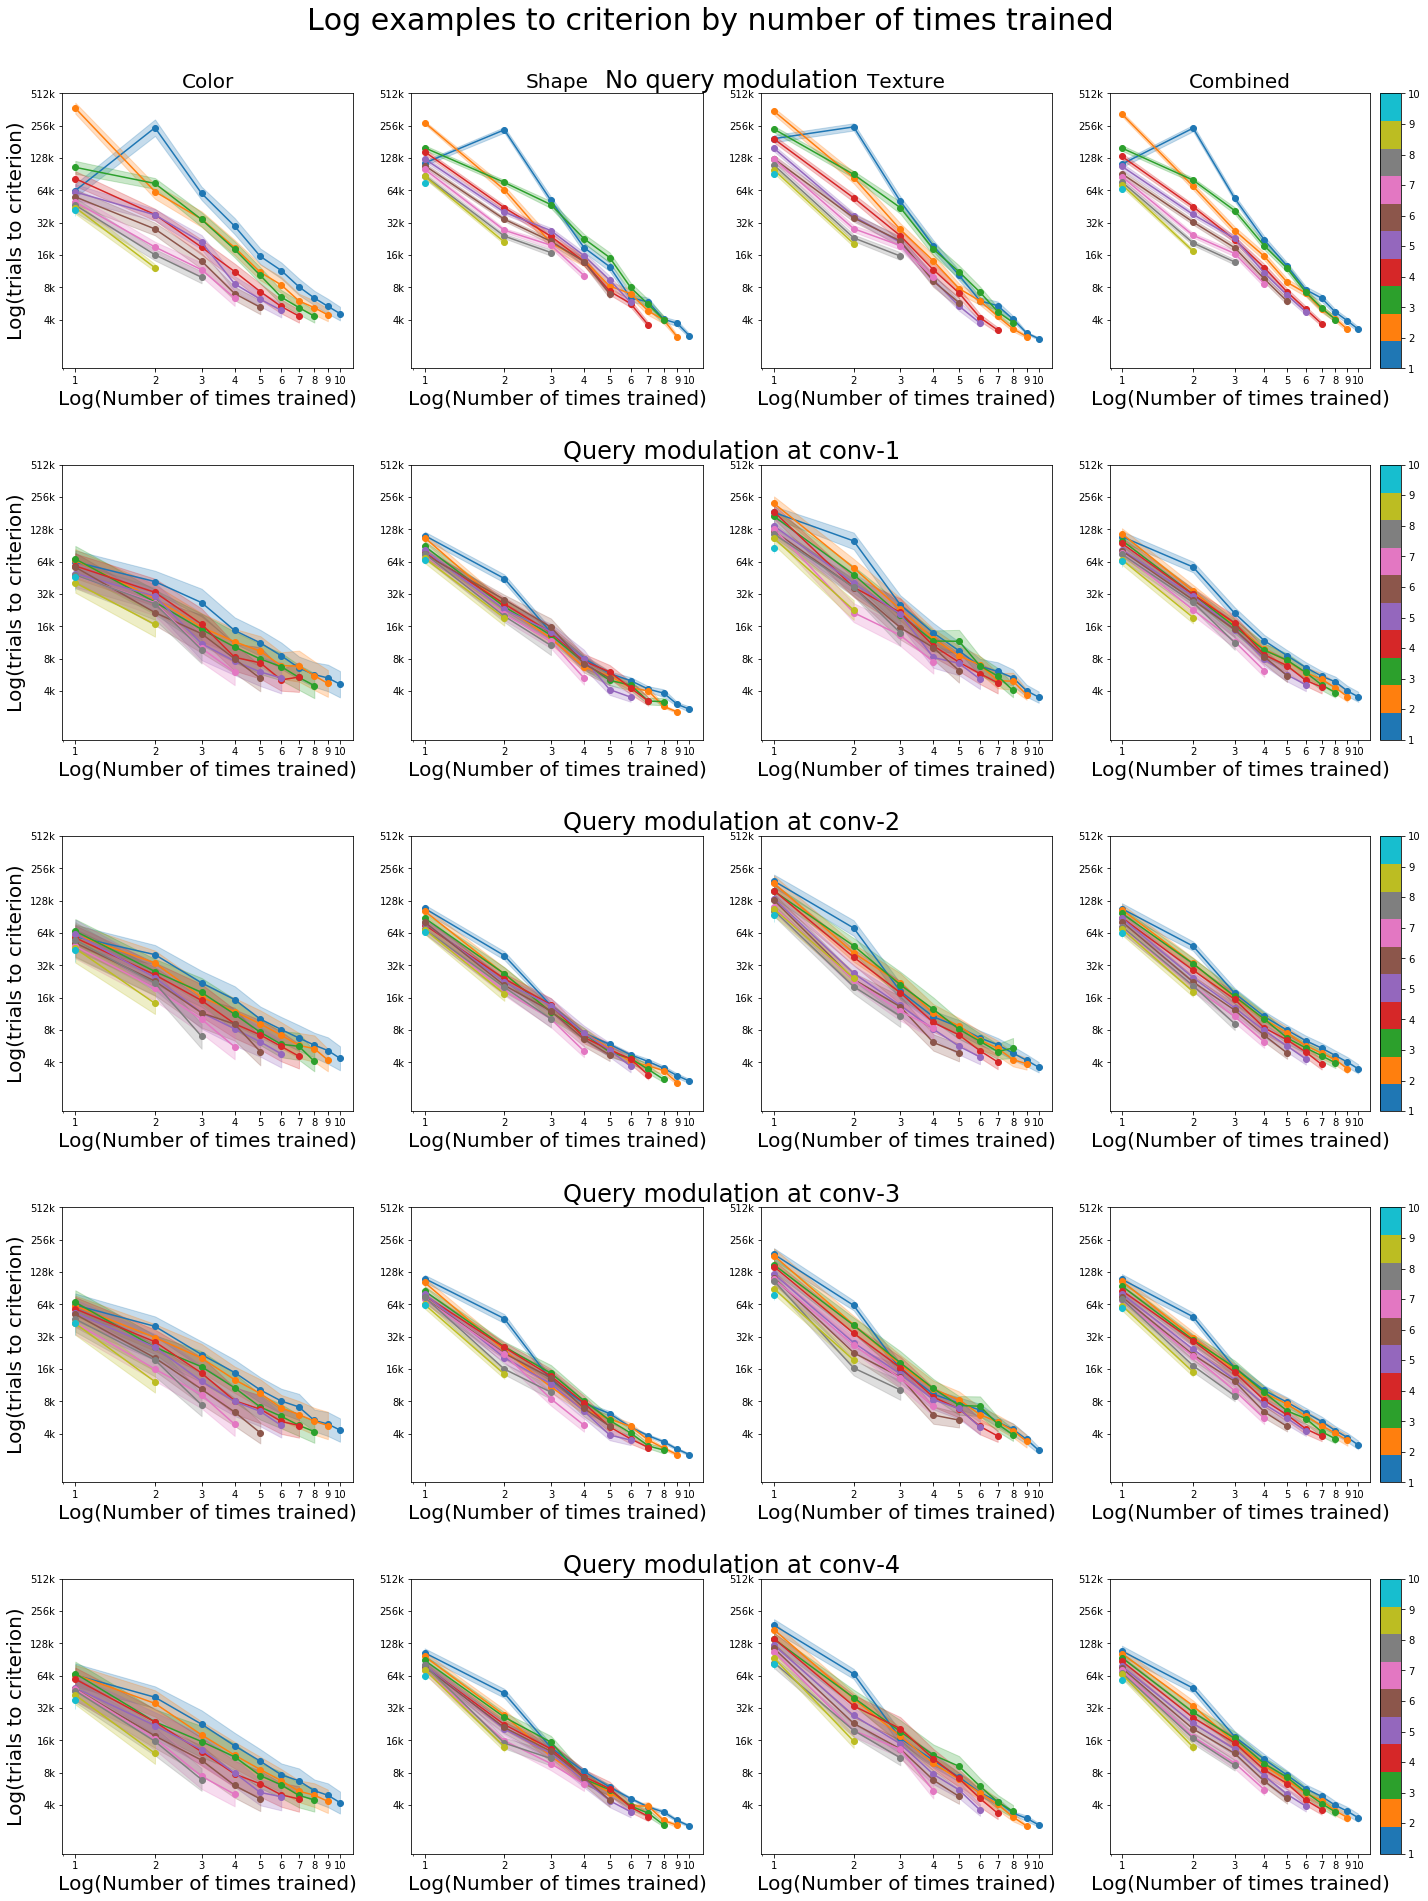

In [8]:
ylim = (7.25, 13)
fonts = dict(fontsize=20)
plots.plot_per_model_per_dimension(six_replications_analyses, query_mod_replications, 
                                   plots.examples_by_times_trained_on, 
                                   'Log examples to criterion by number of times trained',
                                   fonts, ylim=ylim, sem_n=(20, 20, 20, 60), baseline_sem_n=(60, 60, 60, 180))

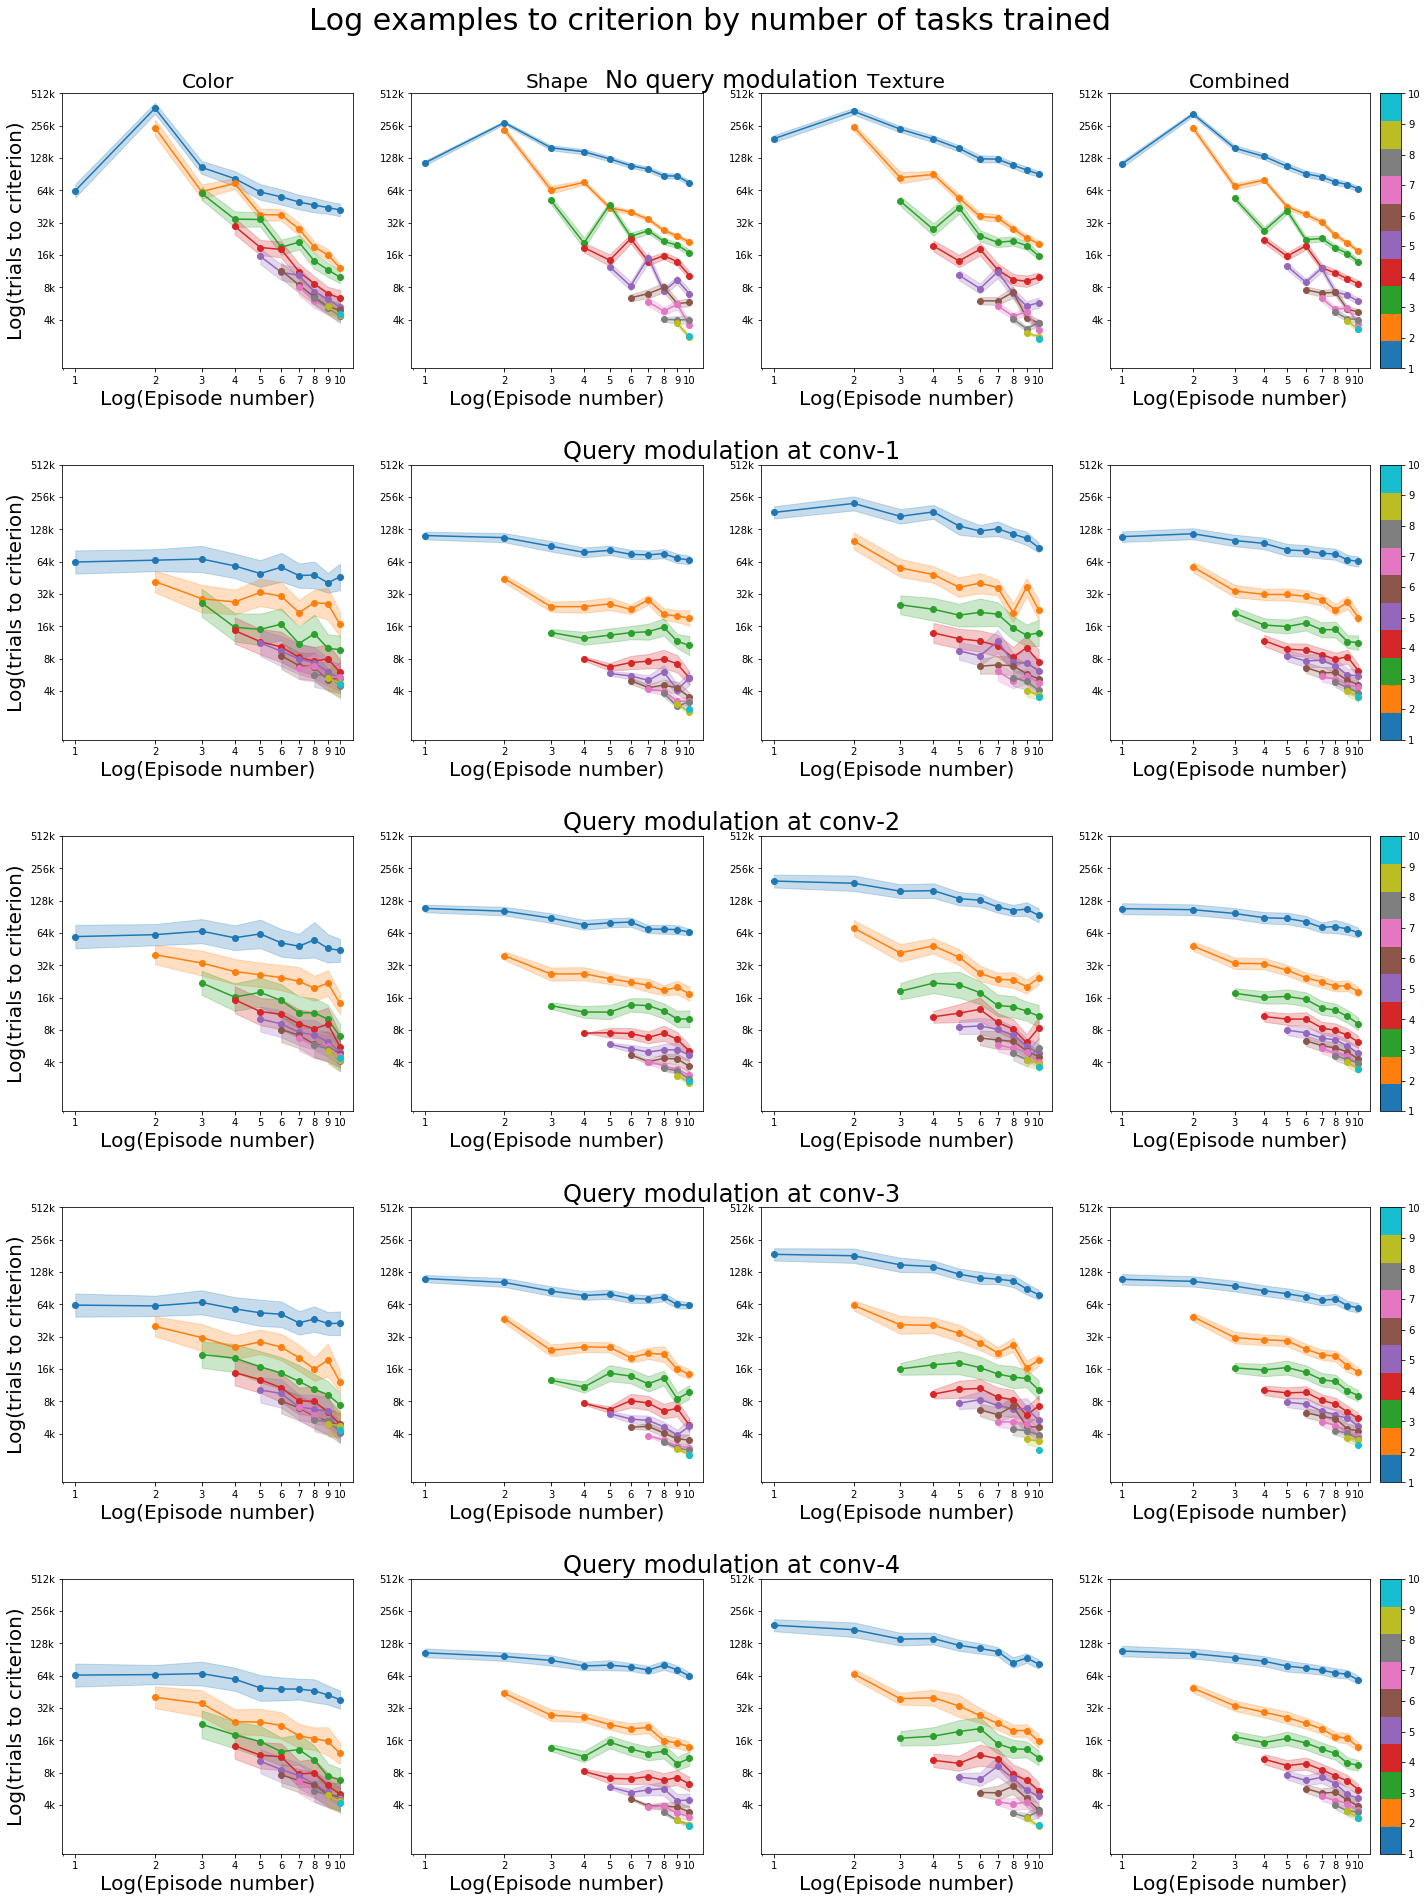

In [9]:
plots.plot_per_model_per_dimension(six_replications_analyses, query_mod_replications, 
                                   plots.examples_by_num_tasks_trained, 
                                   'Log examples to criterion by number of tasks trained',
                                   fonts, ylim=ylim, sem_n=(20, 20, 20, 60), baseline_sem_n=(60, 60, 60, 180))

## Comparison plots - compare all to second replication level

In [ ]:
fonts = dict(fontsize=20)

comparison_level = 4

plots.comparison_plot_per_model(six_replications_analyses, query_mod_replications, 
                                plots.examples_by_times_trained_on, 
                                f'Examples to criterion compared to modulation level {comparison_level}',
                                comparison_level, conditions=None, comparison_func=np.subtract, 
                                font_dict=fonts, ylim=None, shade_error=False, data_index=1, log_y=False,
                                sem_n=(20, 20, 20, 60), baseline_sem_n=(60, 60, 60, 180))

In [ ]:
fonts = dict(fontsize=20)

comparison_level = 0

plots.comparison_plot_per_model(six_replications_analyses, query_mod_replications, 
                                plots.examples_by_times_trained_on, 
                                f'Examples to criterion compared to modulation level {comparison_level}',
                                comparison_level, conditions=(3,), comparison_func=np.divide, 
                                font_dict=fonts, ylim=None, shade_error=False, 
                                data_index=0, log_x=False, log_y=False, comparison_first=True,
                                sem_n=(20, 20, 20, 60), baseline_sem_n=(60, 60, 60, 180),
                                colormap='cool')

In [ ]:
fonts = dict(fontsize=20)

comparison_level = 4

plots.comparison_plot_per_model(six_replications_analyses, query_mod_replications, 
                                plots.examples_by_times_trained_on, 
                                f'Examples to criterion compared to modulation level {comparison_level}',
                                comparison_level, conditions=(3,), comparison_func=np.divide, 
                                font_dict=fonts, ylim=None, shade_error=False, 
                                data_index=0, log_x=False, log_y=False, comparison_first=False,
                                sem_n=(20, 20, 20, 60), baseline_sem_n=(60, 60, 60, 180),
                                colormap='cool')

In [ ]:
fonts = dict(fontsize=20)

comparison_level = 0

plots.comparison_plot_per_model(six_replications_analyses, query_mod_replications, 
                                plots.examples_by_num_tasks_trained, 
                                f'Examples to criterion compared to modulation level {comparison_level}',
                                comparison_level, conditions=(3,), comparison_func=np.divide, 
                                font_dict=fonts, ylim=None, shade_error=False, 
                                data_index=0, log_y=False, comparison_first=True,
                                sem_n=(20, 20, 20, 60), baseline_sem_n=(60, 60, 60, 180),
                                colormap='cool')

In [ ]:
fonts = dict(fontsize=20)

comparison_level = 4

plots.comparison_plot_per_model(six_replications_analyses, query_mod_replications, 
                                plots.examples_by_num_tasks_trained, 
                                'Log examples to criterion by number of tasks trained',
                                comparison_level, conditions=None, comparison_func=np.subtract, 
                                font_dict=fonts, ylim=None, shade_error=False, data_index=1, log_y=False,
                                sem_n=(20, 20, 20, 60), baseline_sem_n=(60, 60, 60, 180))

In [ ]:
fonts = dict(fontsize=20)

comparison_level = 4

plots.comparison_plot_per_model(six_replications_analyses, query_mod_replications, 
                                plots.examples_by_num_tasks_trained, 
                                'Log examples to criterion by number of tasks trained',
                                comparison_level, conditions=None, comparison_func=np.divide, 
                                font_dict=fonts, ylim=None, shade_error=False, data_index=0, log_y=False,
                                sem_n=(20, 20, 20, 60), baseline_sem_n=(60, 60, 60, 180))

In [ ]:
fonts = dict(fontsize=20)

comparison_level = 0

plots.comparison_plot_per_model(six_replications_analyses, query_mod_replications, 
                                plots.examples_by_times_trained_on, 
                                f'Accuracy after introducing new task compared to modulation level {comparison_level}',
                                comparison_level, conditions=(3,), 
                                comparison_func=np.subtract, comparison_first=False,
                                font_dict=fonts, ylim=None, shade_error=False, data_index=2, 
                                log_x=False, log_y=False,
                                sem_n=(20, 20, 20, 60), baseline_sem_n=(60, 60, 60, 180),
                                colormap='cool')

In [ ]:
fonts = dict(fontsize=20)

comparison_level = 4

plots.comparison_plot_per_model(six_replications_analyses, query_mod_replications, 
                                plots.examples_by_times_trained_on, 
                                f'Accuracy drop after introducing new task compared to modulation level {comparison_level}',
                                comparison_level, conditions=(3,), comparison_func=np.subtract,
                                font_dict=fonts, ylim=None, shade_error=False, data_index=2, log_y=False,
                                sem_n=(20, 20, 20, 60), baseline_sem_n=(60, 60, 60, 180))

In [ ]:
s = '1231'
s.count('1')

# Scratch work

## Looking for outlines and analyzing the skewness of these distributions

In [ ]:
from scipy.stats import skew, skewtest

In [ ]:
output, examples = process_multiple_runs(six_replications_by_dimension_runs[1], debug=True)

In [ ]:
ex = np.array(examples)

In [ ]:
plt.hist(ex[:,5,9], bins=20)

In [ ]:
pretty_print_results(skew(ex),  floatfmt=".3f")

In [ ]:
res = skewtest(ex)

In [ ]:
res.pvalue < 0.001

## Analyzing the average number of example for each actual query/task

In [10]:
query_difficulty = sum([r[1] for r in six_replications_by_dimension])
query_names = ['blue', 'brown', 'cyan', 'gray', 'green', 'orange', 'pink',
       'purple', 'red', 'yellow', 'cone', 'cube', 'cylinder',
       'dodecahedron', 'ellipsoid', 'octahedron', 'pyramid', 'rectangle',
       'sphere', 'torus', 'chain_mail', 'marble', 'maze', 'metal',
       'metal_weave', 'polka', 'rubber', 'rug', 'tiles', 'wood_plank']
dimension_names = ['color', 'shape', 'texture']

NameError: name 'six_replications_by_dimension' is not defined

NameError: name 'query_difficulty' is not defined

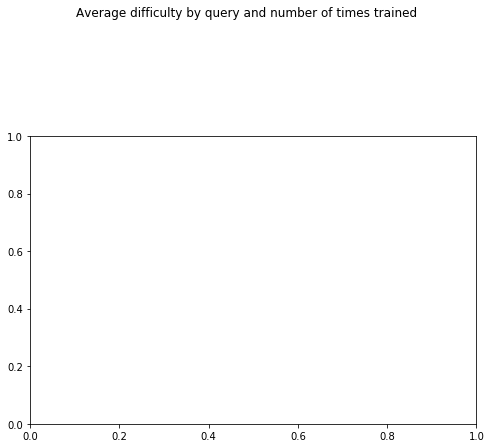

In [11]:
plt.figure(figsize=(8, 18))

plt.suptitle('Average difficulty by query and number of times trained')

for i in range(3):
    ax = plt.subplot(3, 1, i + 1)
    x_values = range(1, 11)
    
    for query_id in range(i * 10, (i + 1) * 10):
        ax.plot(x_values, query_difficulty[query_id,:], label=f'{query_names[query_id]} ({query_id})')
    
    ax.set_title(dimension_names[i])
    ax.set_xlabel('Number of times trained')
    ax.set_ylabel('Average number of examples required')
    ax.legend(loc='best')
    

plt.show()

In [ ]:
a = (1, 2, 3)
b = (4, 5, 6)

{c: d for (c, d) in zip(a, b)}

In [ ]:
np.log((4500, 22500, 45000, 90000, 225000, 450000))

In [ ]:
df = six_replications_by_dimension_runs.combined[0].history()

In [ ]:
samples = 100
first_task_accuracy_per_epoch = np.zeros((10, samples))
first_task_accuracy_per_epoch_counts = np.zeros((10, samples))
new_task_accuracy_per_epoch = np.zeros((10, samples))
new_task_accuracy_per_epoch_counts = np.zeros((10, samples))

In [ ]:
first_task_finished = df['Test Accuracy, Query #2'].first_valid_index() - 1

In [ ]:
first_task_finished

In [ ]:
df[analysis.TASK_ACC_COLS][:first_task_finished + 2]

In [ ]:
df['Test Accuracy, Query #1'][first_task_finished + 1]

In [ ]:
first_task_accuracy_per_epoch[0, 0:first_task_finished] += df['Test Accuracy, Query #1'][1:first_task_finished + 1]

In [ ]:
first_task_accuracy_per_epoch[0, 0:first_task_finished]

In [ ]:
current_task = 2
current_task_start = df[f'Test Accuracy, Query #{current_task}'].first_valid_index()
current_task_end = df[f'Test Accuracy, Query #{current_task + 1}'].first_valid_index()

df[analysis.TASK_ACC_COLS][current_task_start:current_task_end]

In [ ]:
df['Test Accuracy, Query #1'][current_task_start:current_task_end]

In [ ]:
first_task_accuracy_per_epoch[1, 0:current_task_end - current_task_start] = df['Test Accuracy, Query #1'][current_task_start:current_task_end]

In [ ]:
a = np.array(((1, 1, 1, np.nan), (1, 1, 1, np.nan)))
b = np.array(((2, 2, np.nan, np.nan), (2, 2, np.nan, np.nan)))
c = np.array(((3, np.nan, np.nan, np.nan), (3, np.nan, np.nan, np.nan)))

In [ ]:
np.nanmean([a, b, c], axis=0)

In [ ]:
np.nanstd((a, b, c), axis=0)

In [ ]:
control_analyses

In [ ]:
np.max(np.argmax(np.isnan(k), axis=2))

In [ ]:
np.isnan([b, c, a])

In [ ]:
a[:, :3]

In [ ]:
k = np.array([a, b, c])

In [ ]:
k

In [ ]:
k

In [ ]:
np.count_nonzero(~np.isnan(k), axis=0)


In [ ]:
np.divide(a, np.array([3, 2, 1, 1]))

In [ ]:
hasattr(k, 'shape')